In [24]:
%matplotlib inline
import cd_diagrams as cdd
import importlib
import pandas as pd
import numpy as np
import amir_tools as at
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import functools as ft
import matplotlib
import warnings
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats

matplotlib.rc_file_defaults()
datasets = ["ChapmanShaoxing","CPSC2018","PTBXL"]
models = ["inception","minirocket","xresnet1d101"]

In [6]:
def get_scaling_experiments(model_name,dataset,clf_numbers=True,dataset_numbers=True):
    # loads the experiment results
    experiments = []
    for sc in ["0.1","0.25","0.5","0.75","1.0"]:
        try:
            for i in range(20):
                df = pd.read_csv("models/scaling/csvs/%s_%s_sc-n_%s_%s.csv"%(model_name,dataset,sc,i))
                df = df[df.columns[0:-4]]
                df = df.loc[df["index"]=="f1-score"]
                df = df.rename(columns={"index":"classifier_name"})
                df["classifier_name"] = model_name if clf_numbers==False else "%s_%s"%(model_name,sc)
                df["dataset_name"] = dataset if dataset_numbers==False else "%s_%s"%(dataset,i)
                df.index = [i]
                experiments.append(df)
        except Exception as  e:
            print(e)
            continue
    exp_df = pd.concat(experiments)
    return exp_df

def make_cdd_df(exp_df):
    df_median = exp_df.reset_index()[["classifier_name","dataset_name",]]
    df_median["value"] = list(exp_df[exp_df.columns[1:-1]].mean(axis=1).values)
    df_median.columns = ["classifier_name","dataset_name","accuracy"]
    return df_median

def cd_diagram_single_model(exp_df,title="Mean F1",labels=False):
    df_median = make_cdd_df(exp_df)
    cdd.draw_cd_diagram(df_perf=df_median, title=title, labels=labels,alpha=0.05)
    
def draw_scatter_plot(exp_df):
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.set(font_scale = 3)
    data = exp_df.melt(id_vars = "classifier_name")
    data["variable"] = [at.label_shortner(x) for x in data["variable"]]

    #sns.boxplot(data=data,hue="classifier_name",x="variable",y="value",)
    ax = sns.stripplot(data=data,hue="classifier_name",x="variable",y="value",dodge=True,size=8, edgecolor='gray',)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=20,rotation=45)
    ax.set_xlabel("", fontsize = 25)
    ax.set_ylabel("F1 Values", fontsize = 25)
    # ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)
#     plt.legend( fontsize = 16)
#     plt.tight_layout()
    ax.legend(bbox_to_anchor=(1., 1), loc=2, borderaxespad=0.)
    return plt

## per model analysis

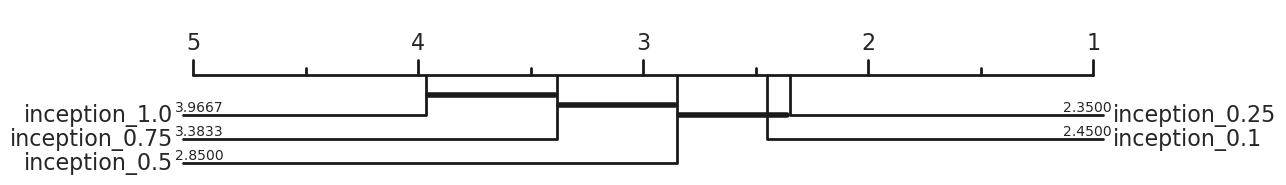

In [134]:
datasets = ["ChapmanShaoxing","CPSC2018","PTBXL"]
inception_dfs = []
for dataset in datasets:
    model_name = "inception"
    exp_df = get_scaling_experiments(model_name,dataset)
    inception_dfs.append(exp_df)
df_inception = pd.concat([make_cdd_df(x) for x in inception_dfs])
plt,_,_ = cdd.draw_cd_diagram(df_perf=df_inception,alpha=0.05,labels=True)
fig.savefig('images/%s_performance_all.pdf'%model_name)

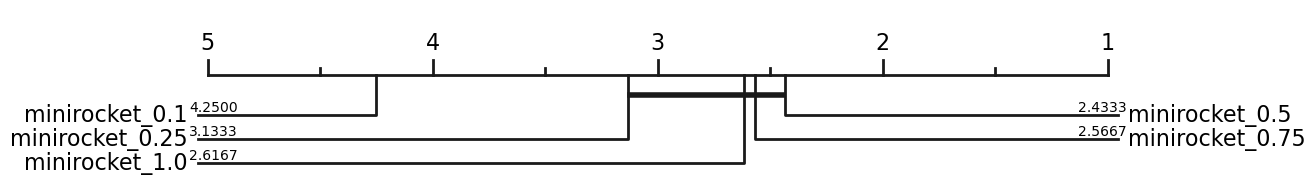

In [18]:
minirocket_dfs = []
for dataset in datasets:
    model_name = "minirocket"
    exp_df = get_scaling_experiments(model_name,dataset)
    minirocket_dfs.append(exp_df)
df_minirocket = pd.concat([make_cdd_df(x) for x in minirocket_dfs])
plt,_,_ = cdd.draw_cd_diagram(df_perf=df_minirocket,alpha=0.05,labels=True)
fig.savefig('images/%s_performance_all.pdf'%model_name)

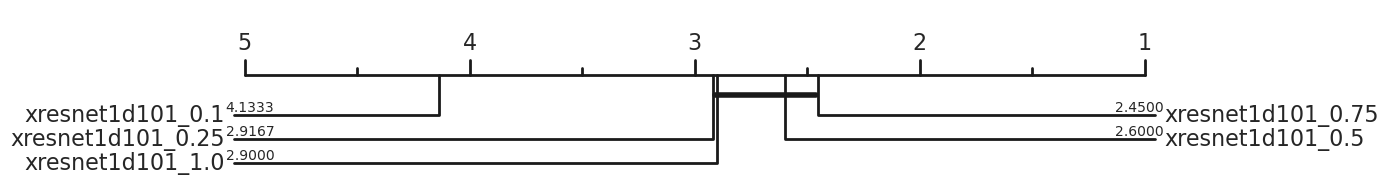

In [285]:
xresnet_dfs = []
for dataset in datasets:
    model_name = "xresnet1d101"
    exp_df = get_scaling_experiments(model_name,dataset)
    xresnet_dfs.append(exp_df)
df_xresnet = pd.concat([make_cdd_df(x) for x in xresnet_dfs])
plt,_,_ = cdd.draw_cd_diagram(df_perf=df_xresnet,alpha=0.05,labels=True)
fig.savefig('images/%s_performance_all.pdf'%model_name)

# factor analysis

In [449]:
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
factor_dfs = []
for db_num in range(3):
    for perf_df in [minirocket_dfs,inception_dfs,xresnet_dfs]:
        df = perf_df[db_num].melt(id_vars=["classifier_name","dataset_name"],var_name=["disease"],value_name="F1")
        df["model"] = df["classifier_name"].apply(lambda x: x.split("_")[0])
        df["rate"] = df["classifier_name"].apply(lambda x: float(x.split("_")[1])*500)
        df["dataset"] = df["dataset_name"].apply(lambda x: x.split("_")[0])
        df["bootstrap_num"] = df["dataset_name"].apply(lambda x: x.split("_")[1])
        df = df.drop(columns=["classifier_name","dataset_name"])
        factor_dfs.append(df)
pd.concat(factor_dfs).to_csv("csvs/model_performance.csv",index=False)

# correlations between sampling rate and performance (per model)

In [383]:
# need a dataframe with columns : disease sampling_rate F1_score
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
corr_dfs = []
model_dfs = minirocket_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
print("overall:",corr_df.corr()["value"][0])
# for each dataset
for i,df in enumerate(model_dfs):
    corr_df = df[df.columns[0:-1]].melt(id_vars=["classifier_name"]).drop(columns=["variable"])
    corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
    print(dataset_names[i],corr_df.corr("spearman")["value"][0])

overall: 0.026242440872476017
chapmanShaoxing 0.009872616061241617
CPSC 0.03252833627702543
PTBXL 0.06288917343906603


In [384]:
# need a dataframe with columns : disease sampling_rate F1_score
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
corr_dfs = []
model_dfs = inception_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
print("overall:",corr_df.corr()["value"][0])
# for each dataset
for i,df in enumerate(model_dfs):
    corr_df = df[df.columns[0:-1]].melt(id_vars=["classifier_name"]).drop(columns=["variable"])
    corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
    print(dataset_names[i],corr_df.corr("spearman")["value"][0])

overall: -0.05466985686638936
chapmanShaoxing -0.06816289945600931
CPSC -0.13104564953147632
PTBXL -0.0038139182750782223


In [385]:
# need a dataframe with columns : disease sampling_rate F1_score
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
corr_dfs = []
model_dfs = xresnet_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
print("overall:",corr_df.corr()["value"][0])
# for each dataset
for i,df in enumerate(model_dfs):
    corr_df = df[df.columns[0:-1]].melt(id_vars=["classifier_name"]).drop(columns=["variable"])
    corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
    print(dataset_names[i],corr_df.corr("spearman")["value"][0])

overall: 0.05358289327976431
chapmanShaoxing 0.09312674787574499
CPSC -0.032353418528183214
PTBXL 0.12195428198109085


# correlation for each dataset (performance)

In [386]:
dset_num = 2 # 0->chapman,1->cpsc, 2->ptbxl
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
disease_list = minirocket_dfs[dset_num].columns[1:-1]
dataset_dfs = []
df = pd.concat([minirocket_dfs[dset_num],inception_dfs[dset_num],xresnet_dfs[dset_num]]) 
# now for each disease in disease_list, do the analysis
disease_dict = {}
for disease_name in disease_list:
    df_perf = df[["classifier_name","dataset_name",disease_name]]
    df_perf = df_perf.rename(columns={disease_name:"accuracy"})


# correlation for all models and datasets (using performance)

In [387]:

dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
corr_dfs = []
model_corr_dfs = []
model_dfs = minirocket_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
model_corr_dfs.append(corr_df)

model_dfs = inception_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
model_corr_dfs.append(corr_df)

model_dfs = xresnet_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
model_corr_dfs.append(corr_df)
pd.concat(model_corr_dfs).corr("spearman")


,classifier_name,value
classifier_name,1.000000,0.003289
value,0.003289,1.000000


# per disease analysis

In [ ]:
# first, select a dataset
# treat each disease as its own dataset, and run the cd analysis for all models. 
# classifier_name -> model+sc
# dataset_name -> disease+dataset (in case there are duplicates)
# acc -> F1 measure

correlation for PTBXL 0.15456041913962368


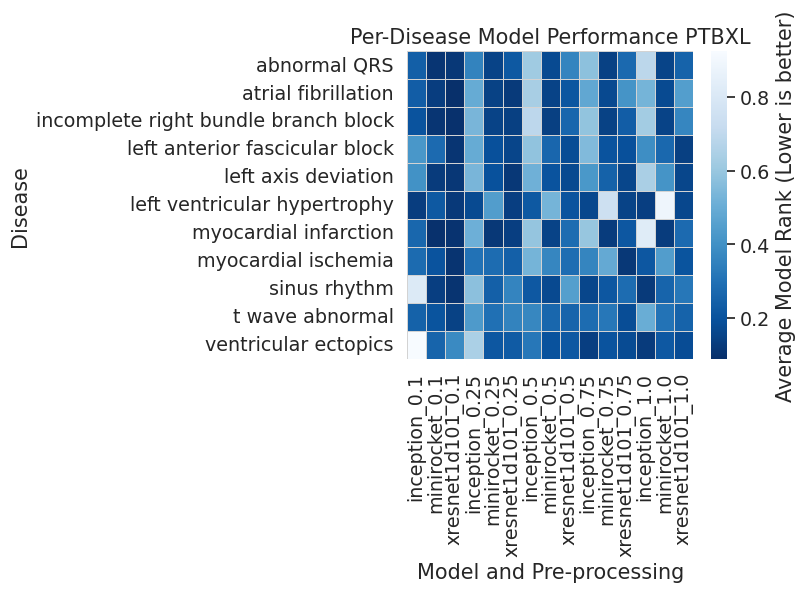

In [462]:

dset_num = 2 # 0->chapman,1->cpsc, 2->ptbxl
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
disease_list = minirocket_dfs[dset_num].columns[1:-1]
dataset_dfs = []
df = pd.concat([minirocket_dfs[dset_num],inception_dfs[dset_num],xresnet_dfs[dset_num]]) 
# now for each disease in disease_list, do the analysis
disease_dict = {}
for disease_name in disease_list:
    df_perf = df[["classifier_name","dataset_name",disease_name]]
    df_perf = df_perf.rename(columns={disease_name:"accuracy"})
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        a,disease_dict[disease_name],b = cdd.wilcoxon_holm(df_perf=df_perf, alpha=0.05,ranking="MRR")

hm_df = pd.DataFrame(disease_dict).T
hm_df = hm_df[hm_df.columns[np.argsort([float(i.split("_")[-1]) for i in hm_df.columns])]] # sort by scaling value

# correlation
corr_df = hm_df.reset_index().melt(id_vars=["index"]).drop(columns="index")
corr_df["variable"] = corr_df["variable"].apply(lambda x: float(x.split("_")[-1])*500)
print("correlation for "+dataset_names[dset_num], corr_df.corr()["value"][0])
### 
ax = sns.heatmap(hm_df, linewidths=.5, linecolor='lightgray',cmap=sns.color_palette("Blues", as_cmap=True).reversed())

sns.set(rc = {'figure.figsize':(8,6)})
sns.set(font_scale = 1.25)

# Manually specify colorbar labelling after it's been generated
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([-1, 0, 1])
# colorbar.set_ticklabels(['B', 'A', 'C'])
# X - Y axis labels
ax.set_ylabel('Disease')
ax.set_xlabel('Model and Pre-processing')
ax.set_title("Per-Disease Model Performance %s"%dataset_names[dset_num])
colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([])

colorbar.ax.set_ylabel('Average Model Rank (Lower is better)',)

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
# _, labels = plt.yticks()
# plt.setp(labels, rotation=0)
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/Per-Disease_Model_Performance_%s.pdf'%dataset_names[dset_num])

In [463]:
df_perf

,classifier_name,dataset_name,accuracy
0,minirocket_0.1,PTBXL_0,0.660099
1,minirocket_0.1,PTBXL_1,0.685714
2,minirocket_0.1,PTBXL_2,0.666667
3,minirocket_0.1,PTBXL_3,0.647887
4,minirocket_0.1,PTBXL_4,0.589286
...,...,...,...
15,xresnet1d101_1.0,PTBXL_15,0.480874
16,xresnet1d101_1.0,PTBXL_16,0.536170
17,xresnet1d101_1.0,PTBXL_17,0.520231
18,xresnet1d101_1.0,PTBXL_18,0.632124


In [459]:
# all datasets combined 
importlib.reload(cdd)
dataset_names = {0:"chapman",1:"CPSC",2:"PTBXL"}

disease_dict = {}
for dset_num in range(3):
    disease_list = minirocket_dfs[dset_num].columns[1:-1]
    df = pd.concat([minirocket_dfs[dset_num],inception_dfs[dset_num],xresnet_dfs[dset_num]]) 
    # now for each disease in disease_list, do the analysis

    for disease_name in disease_list:
        df_perf = df[["classifier_name","dataset_name",disease_name]]
        df_perf = df_perf.rename(columns={disease_name:"accuracy"})
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            disease_dict[disease_name+"-"+dataset_names[dset_num]] = cdd.wilcoxon_holm(df_perf=df_perf, alpha=0.05,ranking="MRR")[1]



hm_df = pd.DataFrame(disease_dict).T
hm_df.shape

(26, 15)

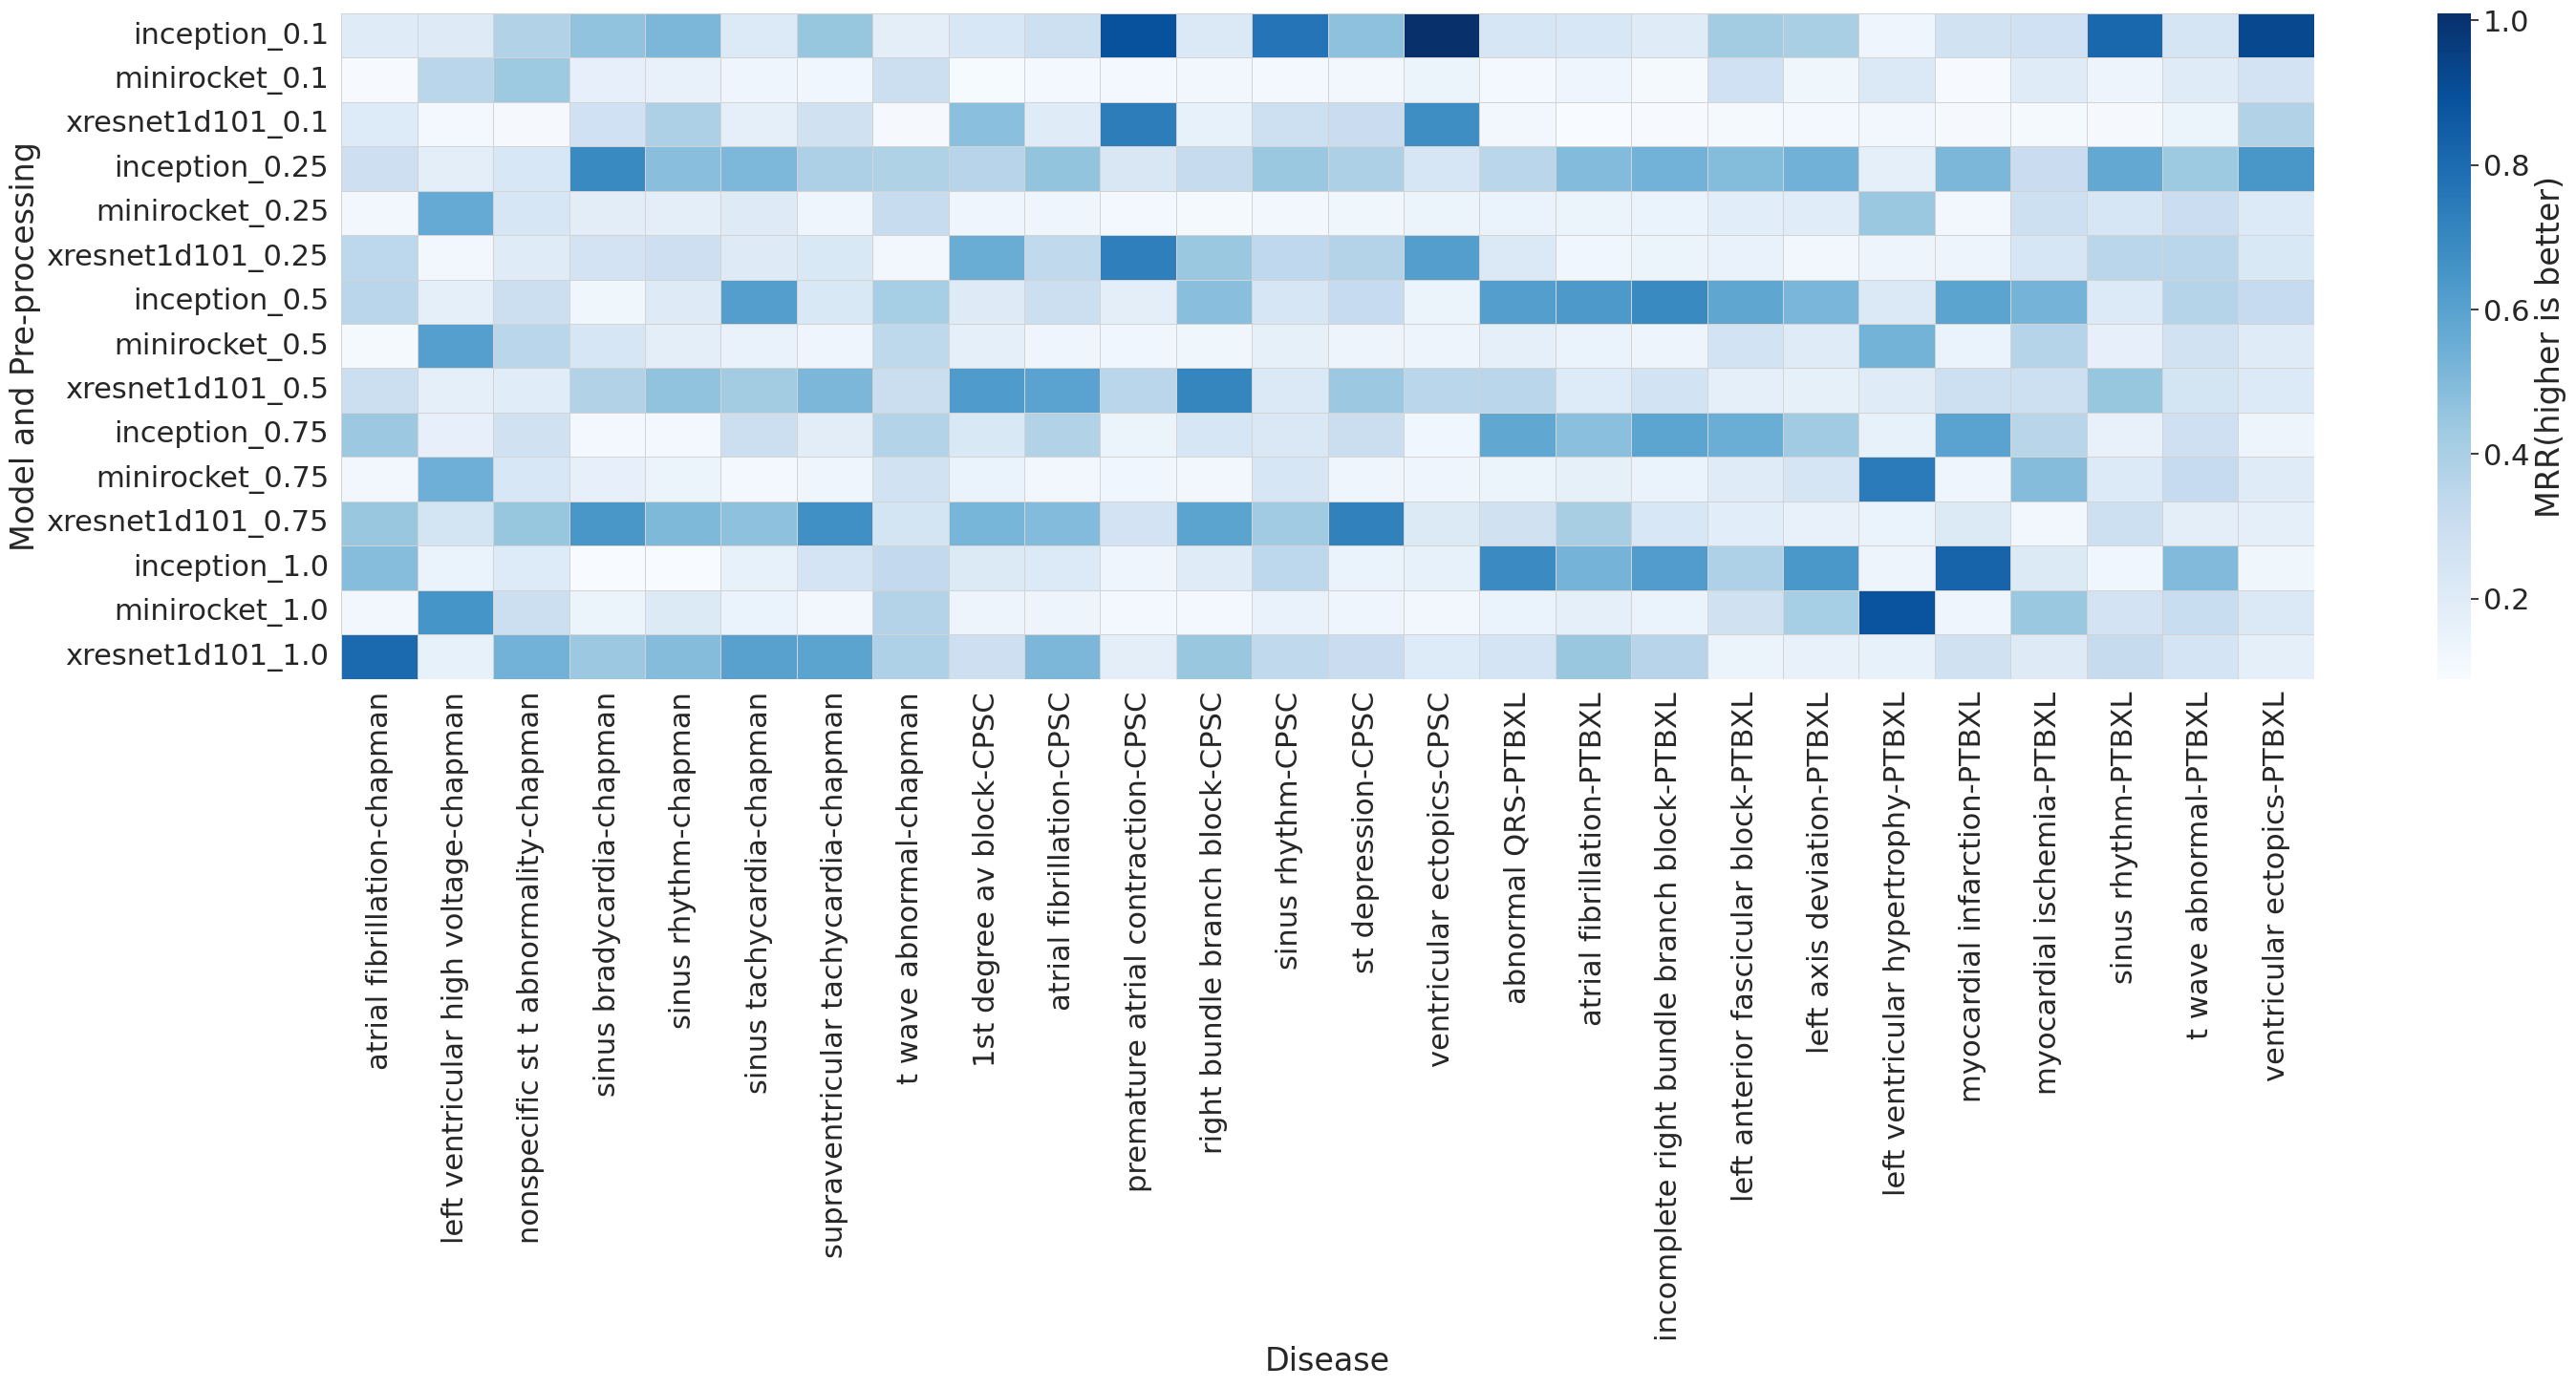

In [451]:
hm_df = pd.DataFrame(disease_dict).T
hm_df = hm_df[hm_df.columns[np.argsort([float(i.split("_")[-1]) for i in hm_df.columns])]] # sort by scaling value

ax = sns.heatmap(hm_df.T, linewidths=.5, linecolor='lightgray',cmap=sns.color_palette("Blues", as_cmap=True))

sns.set(rc = {'figure.figsize':(30,15)})
sns.set(font_scale = 2)

# Manually specify colorbar labelling after it's been generated
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([-1, 0, 1])
# colorbar.set_ticklabels(['B', 'A', 'C'])
# X - Y axis labels
ax.set_xlabel('Disease')
ax.set_ylabel('Model and Pre-processing')
# ax.set_title("Per-Disease Model Performance "%dataset_names[dset_num])
colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([])

colorbar.ax.set_ylabel('MRR(higher is better)',)

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
# _, labels = plt.yticks()
# plt.setp(labels, rotation=0)
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/Per-Disease_Model_Performance_all.pdf')

# correlation between sampling rate and ranks
- for all
- for all models

In [388]:
# per model
corr_df = hm_df.T
corr_df = corr_df.reset_index().melt(id_vars=["index"]).drop(columns=["variable"]) 
corr_df["index"] = corr_df["index"].apply(lambda x: float(x.split("_")[-1])*500)
corr_df
corr_df.corr(method="spearman")

,index,value
index,1.000000,0.078365
value,0.078365,1.000000


In [354]:
# per model


for m in models:
    corr_df = hm_df.T
    corr_df = corr_df[corr_df.index.str.contains(m)].reset_index().melt(id_vars=["index"]).drop(columns=["variable"]) 
    corr_df["index"] = corr_df["index"].apply(lambda x: float(x.split("_")[-1])*500)
    
    print(m,corr_df.corr(method="spearman")["value"][0])

inception 0.2662065879335514
minirocket -0.17017624198802214
xresnet1d101 -0.3233137408798818


# correlations

In [ ]:
# all datasets combined 
importlib.reload(cdd)
dataset_names = {0:"chapman",1:"CPSC",2:"PTBXL"}

disease_dict = {}
for dset_num in range(3):
    disease_list = minirocket_dfs[dset_num].columns[1:-1]
    df = pd.concat([minirocket_dfs[dset_num],inception_dfs[dset_num],xresnet_dfs[dset_num]]) 
    # now for each disease in disease_list, do the analysis

    for disease_name in disease_list:
        df_perf = df[["classifier_name","dataset_name",disease_name]]
        df_perf = df_perf.rename(columns={disease_name:"accuracy"})
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            disease_dict[disease_name+"-"+dataset_names[dset_num]] = cdd.wilcoxon_holm(df_perf=df_perf, alpha=0.05,)[1]



hm_df = pd.DataFrame(disease_dict).T
hm_df

## per dataset analysis
- classifier_names = model_HZ
- dataset name = datset + bootstrap#
- accuracy = F1

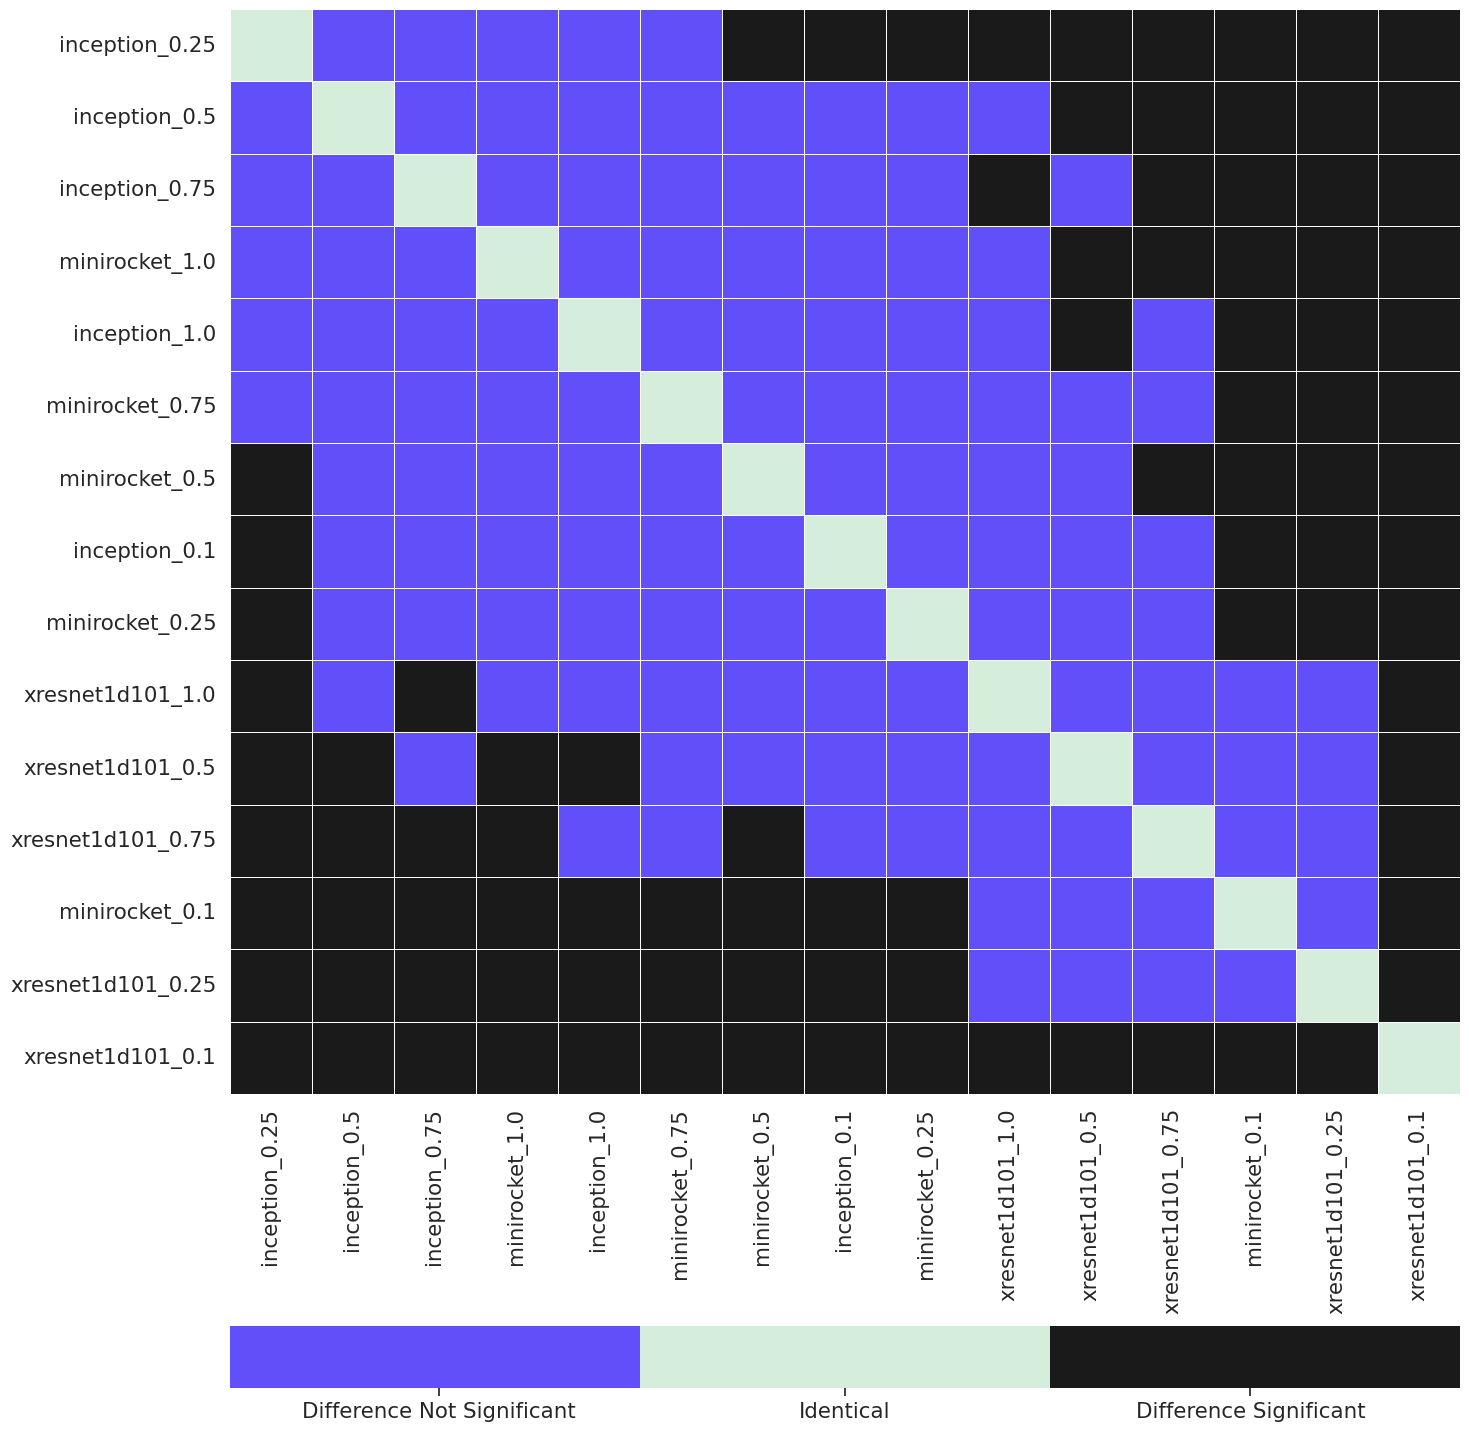

In [25]:
dataset = "PTBXL"
dataset_dfs = []
for model_name in models[0:3]:
    exp_df = get_scaling_experiments(model_name,dataset)
    dataset_dfs.append(exp_df)
p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
# given a model, find whether it's significantly better than the one ranked below it
m_list = list(avg_rank.index)  #sorted list of models by avg rank
p_vals = pd.DataFrame(p_vals)
# make a matrix of which models is significantly better than the others
rank_matrix = pd.DataFrame(-1*np.ones([len(m_list),len(m_list)]),index=reversed(m_list),columns=reversed(m_list))
i = 0
for m1 in m_list:
    for m2 in list(reversed(m_list)):
        row = p_vals[((p_vals[0]==m1) & (p_vals[1]==m2)) | (p_vals[1]==m1) & (p_vals[0]==m2)]
        if row.shape[0]>0:
            if row[3].values[0] == True:
                rank_matrix.loc[m1][m2] = 1
        else: 
            rank_matrix.loc[m1][m2] = 0
            
myColors = ((0.1, 0.0, 1, 0.66),(0.5, 1, .5,0.2),(0.1, 0.1, 0.1, 1),)
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
sns.set(rc = {'figure.figsize':(15,16)})
sns.set(font_scale = 1.4)
ax = sns.heatmap(rank_matrix, cmap=cmap, linewidths=0.5,cbar_kws={"orientation": "horizontal"})
# ax.set_title("Model Comparisons for %s"%dataset)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.66, 0, .66])

colorbar.set_ticklabels(['Difference Not Significant', 'Identical', 'Difference Significant'])
ax.tick_params(axis='x', rotation=90)
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/model_comparisons_%s.pdf'%dataset)

## all models, all datasets
- classifier_names = model_HZ
- dataset name = datset + bootstrap#
- accuracy = F1
### Method 1, pool all performane dfs together and run test
### Method 2, get rank matrices, and average them 

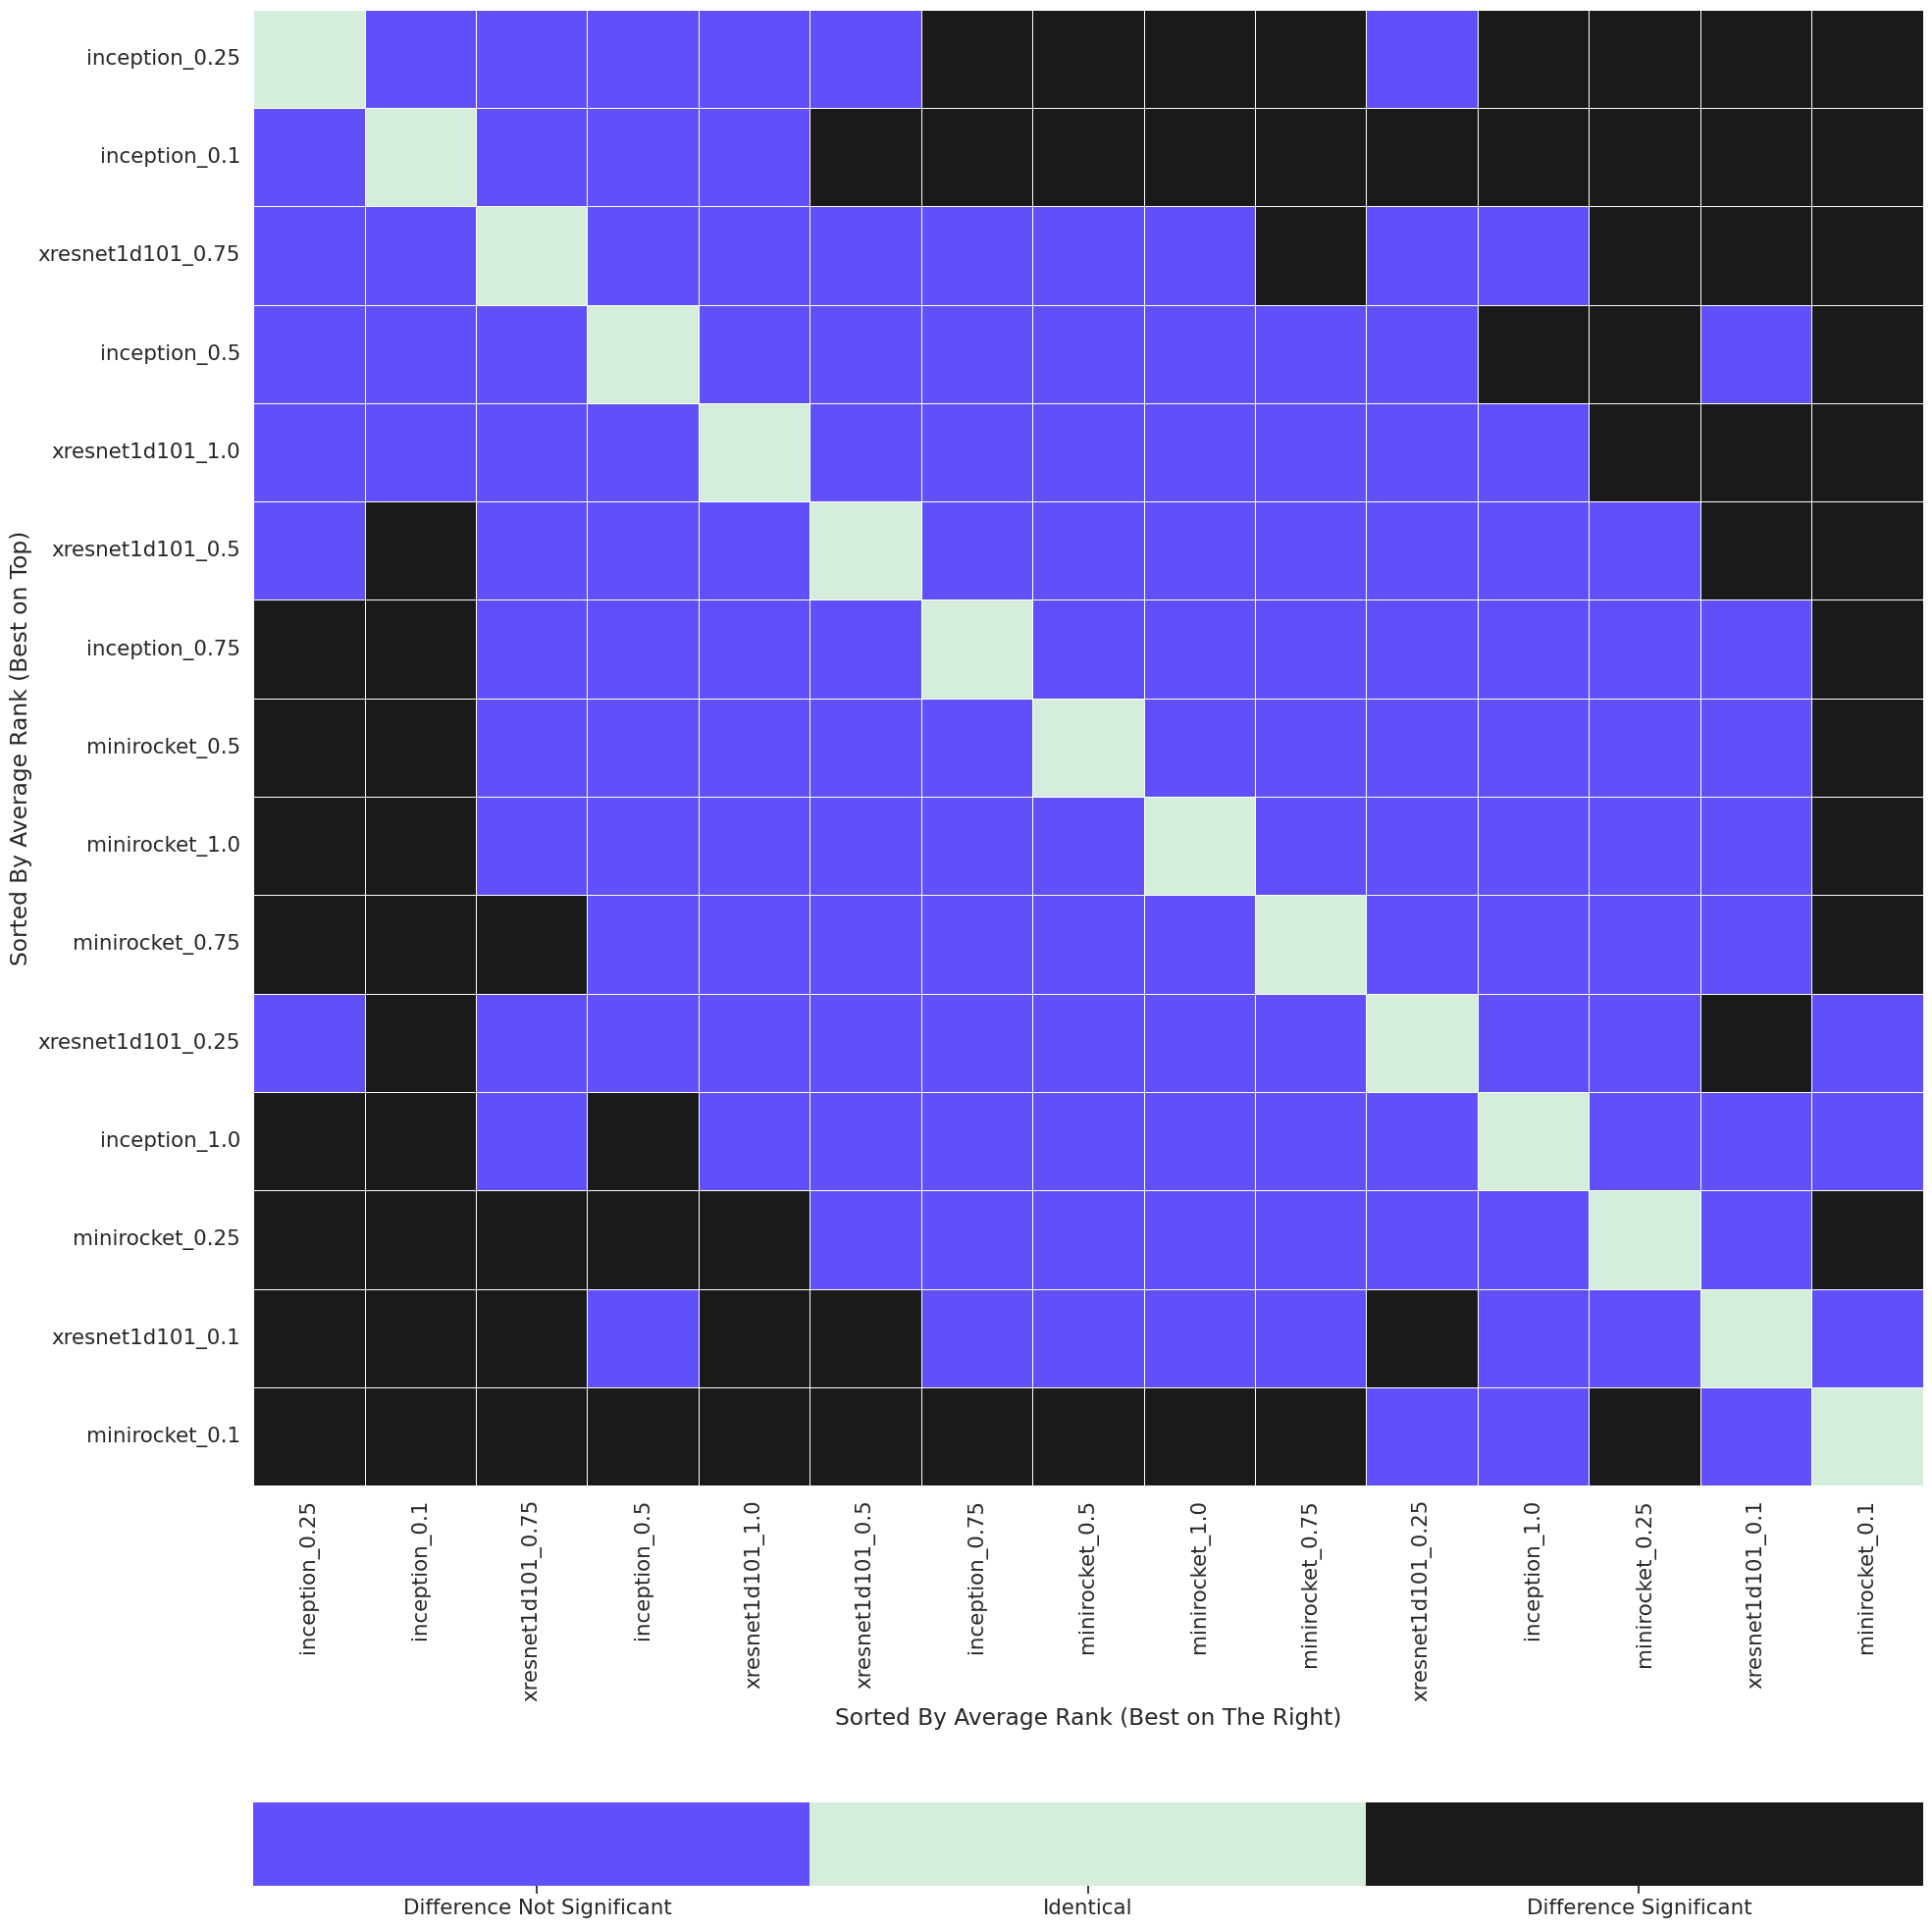

In [26]:
dataset_dfs = []
for model_name in models[0:3]:
    for dataset in datasets:
        exp_df = get_scaling_experiments(model_name,dataset)
        dataset_dfs.append(exp_df)
p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
# given a model, find whether it's significantly better than the one ranked below it
m_list = list(avg_rank.index)  #sorted list of models by avg rank
p_vals = pd.DataFrame(p_vals)
# make a matrix of which models is significantly better than the others
rank_matrix = pd.DataFrame(-1*np.ones([len(m_list),len(m_list)]),index=reversed(m_list),columns=reversed(m_list))
i = 0
for m1 in m_list:
    for m2 in list(reversed(m_list)):
        row = p_vals[((p_vals[0]==m1) & (p_vals[1]==m2)) | (p_vals[1]==m1) & (p_vals[0]==m2)]
        if row.shape[0]>0:
            if row[3].values[0] == True:
                rank_matrix.loc[m1][m2] = 1
        else: 
            rank_matrix.loc[m1][m2] = 0
myColors = ((0.1, 0.0, 1, 0.66),(0.5, 1, .5,0.2),(0.1, 0.1, 0.1, 1),)
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
sns.set(rc = {'figure.figsize':(20,22)})
sns.set(font_scale = 1.4)
ax = sns.heatmap(rank_matrix, cmap=cmap, linewidths=0.5,cbar_kws={"orientation": "horizontal"})
# ax.set_title("Model Comparisons for All Datasets")
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.66, 0, .66])

colorbar.set_ticklabels(['Difference Not Significant', 'Identical', 'Difference Significant'])
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Sorted By Average Rank (Best on Top)')
ax.set_xlabel('Sorted By Average Rank (Best on The Right)')
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/model_comparisons_alldatasets.pdf')

In [27]:
# Method 2
dataset_dfs = []
avg_ranks = []
for dataset in datasets:
    for model_name in models[0:3]:
        exp_df = get_scaling_experiments(model_name,dataset)
        dataset_dfs.append(exp_df)
    p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
    avg_ranks.append(avg_rank)
(sum(avg_ranks)/len(avg_ranks)).sort_values()

inception_0.1         5.075000
inception_0.25        5.172222
xresnet1d101_0.75     5.380556
xresnet1d101_1.0      5.755556
xresnet1d101_0.5      6.672222
minirocket_0.5        7.675000
inception_0.5         7.847222
minirocket_1.0        8.391667
minirocket_0.75       8.472222
inception_0.75        8.494444
minirocket_0.25       8.891667
xresnet1d101_0.25     9.216667
inception_1.0        10.441667
minirocket_0.1       11.150000
xresnet1d101_0.1     11.363889
dtype: float64

# other stuff

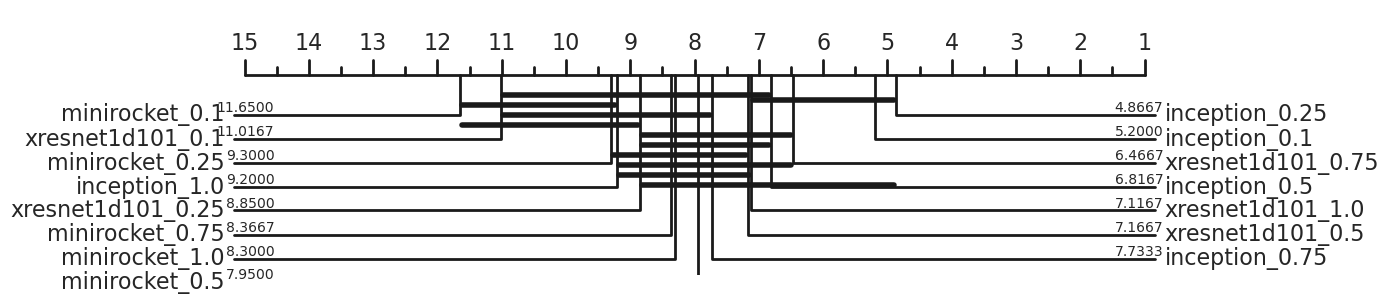

In [28]:
importlib.reload(cdd)
df_perf = pd.concat([df_xresnet,df_inception,df_minirocket])
plt,p_vals,avg_rank = cdd.draw_cd_diagram(df_perf=df_perf,alpha=0.05,labels=True,)

In [ ]:
stats = pd.DataFrame(p_vals,columns=["model_1","model_2","p_val","significant"])
# stats[(stats["model_1"]=="inception_1.0")]
avg_rank

# scatter plots

In [ ]:

for dataset in datasets:
    model_name = "minirocket"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
# ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

NameError: name 'ax' is not defined

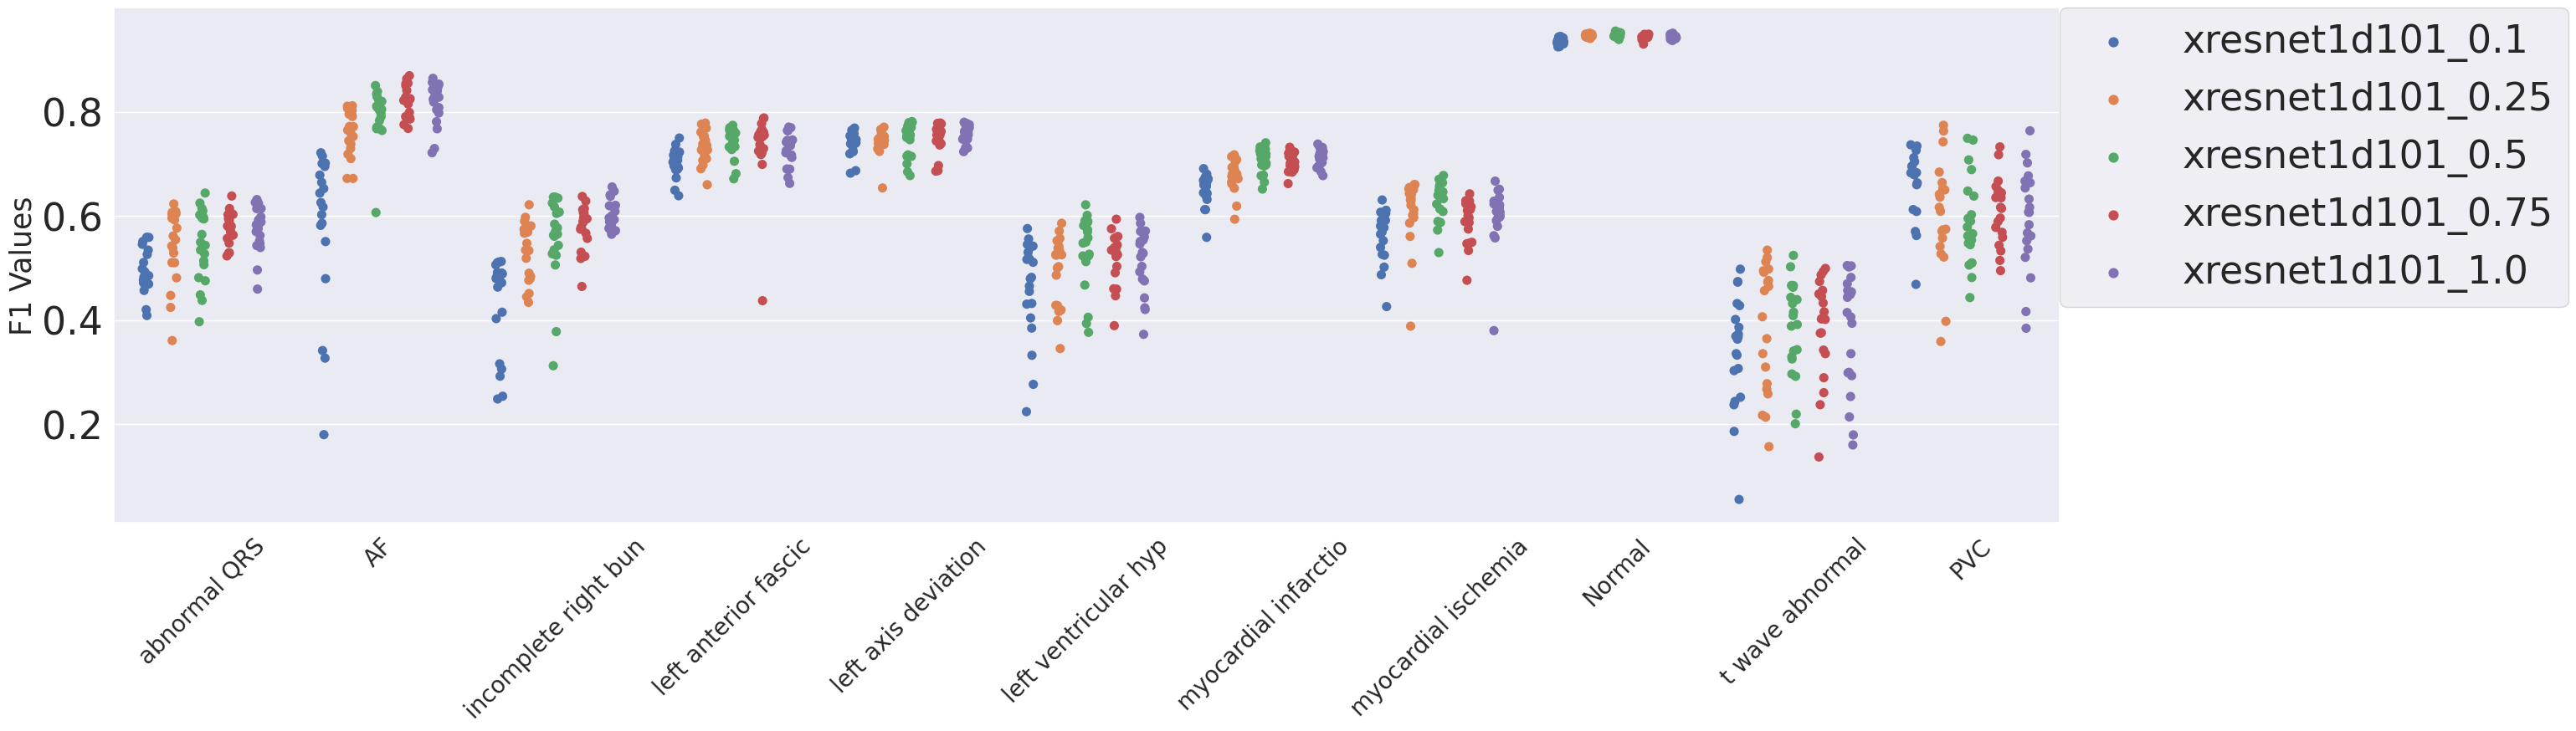

In [4]:
for dataset in datasets:
    model_name = "xresnet1d101"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

In [ ]:
for dataset in datasets:
    model_name = "inception"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
# ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

In [ ]:
# compare inception and xresnet ( or any two models)
model_1 = "inception"
model_2 = "xresnet1d101"
exp_1 = get_scaling_experiments(model_1,dataset,dataset_numbers=False).drop(columns=["dataset_name"]).groupby("classifier_name").median()
exp_2 = get_scaling_experiments(model_2,dataset,dataset_numbers=False).drop(columns=["dataset_name"]).groupby("classifier_name").median()


In [ ]:
# get difference between the 20 model experiments for each disease
pd.DataFrame(exp_2.values-exp_1.values,columns = exp_1.columns,index=[int(np.float32(x.split("_")[1])*500) for x in exp_1.index])

# abram tests

In [465]:
df = pd.read_csv("csvs/model_performance.csv")
df

,disease,F1,model,rate,dataset,bootstrap_num
0,atrial fibrillation,0.776280,minirocket,50.0,ChapmanShaoxing,0
1,atrial fibrillation,0.817143,minirocket,50.0,ChapmanShaoxing,1
2,atrial fibrillation,0.790960,minirocket,50.0,ChapmanShaoxing,2
3,atrial fibrillation,0.768392,minirocket,50.0,ChapmanShaoxing,3
4,atrial fibrillation,0.840336,minirocket,50.0,ChapmanShaoxing,4
...,...,...,...,...,...,...
7795,ventricular ectopics,0.480874,xresnet1d101,500.0,PTBXL,15
7796,ventricular ectopics,0.536170,xresnet1d101,500.0,PTBXL,16
7797,ventricular ectopics,0.520231,xresnet1d101,500.0,PTBXL,17
7798,ventricular ectopics,0.632124,xresnet1d101,500.0,PTBXL,18


In [469]:
# correlation between rate and performance for each disease 
gb = df.groupby("disease")
groups = [[gb.get_group(x),x] for x in gb.groups]
[[x[1],x[0][["rate","F1"]].corr(method="pearson")["F1"][0]] for x in groups]

[['1st degree av block', 0.02386278766363522],
 ['abnormal QRS', 0.32629932225273967],
 ['atrial fibrillation', 0.17787464134638126],
 ['incomplete right bundle branch block', 0.3780781879198854],
 ['left anterior fascicular block', 0.03972997698008977],
 ['left axis deviation', 0.2356357628658654],
 ['left ventricular high voltage', 0.0777855788736667],
 ['left ventricular hypertrophy', 0.18617922197292666],
 ['myocardial infarction', 0.37836247254814614],
 ['myocardial ischemia', 0.07328463549580955],
 ['nonspecific st t abnormality', 0.22362609440646472],
 ['premature atrial contraction', -0.3221213975829072],
 ['right bundle branch block', 0.0523521716925105],
 ['sinus bradycardia', -0.3326455521639097],
 ['sinus rhythm', -0.014171116628929255],
 ['sinus tachycardia', 0.04137550403858546],
 ['st depression', -0.09413606495477017],
 ['supraventricular tachycardia', 0.006292889965725261],
 ['t wave abnormal', 0.07197577219867152],
 ['ventricular ectopics', -0.3644861970281147]]

In [474]:
# kruskal wallice for all factors, when looking at the F1 value
for c in df.columns:
    gb = df.groupby(c)
    groups = [[gb.get_group(x),x] for x in gb.groups]

    print(c,stats.kruskal(*[g[0]["F1"].values for g in groups]))

disease KruskalResult(statistic=6454.316088870336, pvalue=0.0)
F1 KruskalResult(statistic=7799.000000000002, pvalue=8.349890612673466e-76)
model KruskalResult(statistic=19.135081617041397, pvalue=6.996322518088917e-05)
rate KruskalResult(statistic=4.317652717070552, pvalue=0.36471983136283653)
dataset KruskalResult(statistic=643.6270163063753, pvalue=1.7304904509292142e-140)
bootstrap_num KruskalResult(statistic=2.50860493565756, pvalue=0.9999975434057621)


In [505]:
# for which diseases is rate a factor? 
gb = df.groupby("disease")
groups = [[gb.get_group(x),x] for x in gb.groups]
# [stats.kruskal(x[0]["F1"]) for x in groups]
for data,g in groups:
    gb = data.groupby("rate")
    result = stats.kruskal(*[gb.get_group(x)["F1"] for x in gb.groups])
    print(g,results) if result[0]<0.05 else pass

SyntaxError: invalid syntax (2340195432.py, line 8)

In [503]:
stats.kruskal(*[gb.get_group(x)["F1"] for x in gb.groups])[1]

4.021685526467609e-21